In [20]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
import yfinance as yf 
import datetime 
import talib 
import keras 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from keras.regularizers import l1 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBClassifier, plot_importance
from numpy.random import seed 
from imblearn.over_sampling import SMOTE 
from keras.optimizers import Adam 
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout 
# from tensorflow import set_random_seed 
from sklearn.model_selection import StratifiedKFold 
import warnings 
warnings.filterwarnings('ignore') 

#### Modifying dataframes to make open as the target column

In [2]:
def FORCE(data,n):
    F = pd.Series(data['Close'].shift(1).diff(n) * data['Volume'].shift(1).diff(n), name = 'Force_' + str(n))  
    return F  

In [3]:
def create_features(data,column):
    #Creating Target Variable
    data['Returns'] = np.log(data[column]/data[column].shift(1)) 
    data['Directions'] = np.sign(data['Returns']) 
    data['Directions'] = np.where(data['Directions'] == 1,1,0)
    data['Directions'] = data['Directions'] 

    data['H-L'] = data['High'].shift(1)-data['Low'].shift(1)
    data['O-L'] = data['Open'].shift(1)-data['Low'].shift(1)
    data['C-L'] = data['Close'].shift(1)-data['Low'].shift(1)
    data['H-O'] = data['High'].shift(1)-data['Open'].shift(1)
    data['H-C'] = data['High'].shift(1)-data['Close'].shift(1)
    data['O-C'] = data['Open'].shift(1)-data['Close'].shift(1)

    #Technical indicators 
    data['ATR'] = talib.ATR(data['High'].shift(1).values, data['Low'].shift(1).values, data['Close'].shift(1).values, timeperiod=20)
    data['ADX'] = talib.ADX(data['High'].shift(1).values, data['Low'].shift(1).values, data['Close'].shift(1).values, timeperiod=5)
    data['RSI'] = talib.RSI(data['Close'].shift(1).values, timeperiod=10)
    data['ADOSC'] = talib.ADOSC(data['High'].shift(1).values, data['Low'].shift(1).values, data['Close'].shift(1).values, 
                                np.asarray(data['Volume'].shift(1).values,dtype='float'),fastperiod=5,slowperiod=20)
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = talib.BBANDS(data['Close'].shift(1).values, timeperiod=20)
    data['CCI'] = talib.CCI(data['High'].shift(1).values, data['Low'].shift(1).values, data['Close'].shift(1).values, timeperiod=20)
    data['ROC'] = talib.ROC(data['Close'].shift(1).values, timeperiod=5)
    days_list = [5,10,50,100,200]
    data['FI_1'] = FORCE(data,1)
    data['FI_3'] = FORCE(data,3)
    data['FI_5'] = FORCE(data,5)
    for days in days_list:
        data['sma_%s' % days] = data['Close'].shift(1).rolling(window = days).mean()
        data['ewma_%s' % days]  = talib.EMA(data['Close'].shift(1).values,days)
    return data

In [4]:
def modify_df(df):
    cols = ['High', 'Low', 'Close', 'Adj Close', 'Volume', 'Open', 'Returns',
       'H-L', 'O-L', 'C-L', 'H-O', 'H-C', 'O-C', 'ATR', 'ADX',
       'RSI', 'ADOSC', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'CCI', 'ROC',
       'FI_1', 'FI_3', 'FI_5', 'sma_5', 'ewma_5', 'sma_10', 'ewma_10',
       'sma_50', 'ewma_50', 'sma_100', 'ewma_100', 'sma_200', 'ewma_200', 'Directions']
    modify_df = df[cols] 
    return modify_df 

In [5]:
def balanceData(X,y):
    counts = y['Directions'].value_counts() 
    sum_y1 = counts.get(1, 0)
    sum_y0 = counts.get(0, 0) 
    if(sum_y1/sum_y0<=0.85) or (sum_y0/sum_y1<=0.85):
        sm = SMOTE(random_state=2)
        X, y = sm.fit_sample(X, y)    
    return pd.DataFrame(X),pd.Series(y.values.ravel())  

In [6]:
def data_split(df,year_1,year_2):
    df.dropna(inplace=True) 
    df.index = pd.to_datetime(df.index) 

    trainData = df[(df.index.year>=int(year_1)) & (df.index.year<=int(year_2))]
    testData = df[df.index.year>int(year_2)]

    x_train = trainData.iloc[:,:35]  
    y_train = trainData.iloc[:,-1:]
    x_train, y_train = balanceData(x_train, y_train)
    x_test = testData.iloc[:,:35]  
    y_test = testData.iloc[:,-1:]

    return x_train, x_test, y_train, y_test     

In [7]:
def modelBuildXGB(x,y,n_estimator,learning_rate,max_depth,min_child_weight,gamma,colsample_bytree):
    xgb= XGBClassifier( n_estimator= n_estimator, 
                    learning_rate= learning_rate, 
                    max_depth= max_depth,  
                    min_child_weight=min_child_weight,
                    gamma=gamma,
                    colsample_bytree=colsample_bytree,
                    objective= 'binary:logistic', 
                    random_state= 42,
                    n_jobs=-1)
    xgb.fit(x,y) 
    return xgb

In [8]:
def create_model(x_train, unit, optimizer, kernel_init, activation, reg):
    classifier=Sequential() 
    classifier.add(Dense(units=unit, kernel_initializer=kernel_init, activation=activation,
                         activity_regularizer=reg, input_dim=x_train.shape[1])) 
    classifier.add(Dense(units = 1, kernel_initializer = kernel_init, activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier 

In [9]:
def train_model(model, x_train, y_train,checkpoint,stoppoint,batch_size,epochs):  
    model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_split= 0.3 , 
              callbacks=[checkpoint, stoppoint],verbose=1)
    return model.history 

In [10]:
def plotHistory(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show() 

In [11]:
def plotMetrics(threshold, x_test_scaled, y_test):
    model = load_model('model.keras')
    y_pred = model.predict(x_test_scaled)
    y_pred = (y_pred > threshold)
    accuracy_model = accuracy_score(y_test, y_pred, normalize=True)*100
    print('Accuracy : ',accuracy_model,' %') 
    print('Confusion Matrix : ')
    print(confusion_matrix(y_test,y_pred))
    print('Classification Report : ')
    print(classification_report(y_test,y_pred))
    auc = roc_auc_score(y_test,y_pred)
    print('AUC Score : ',auc) 

In [12]:
start_date = '2018-01-13'
end_date = '2021-01-13'
symbols = ['HDFCBANK.NS','ICICIBANK.NS','SBIN.NS','KOTAKBANK.NS','AXISBANK.NS']

#### 

HDFCBANK.NS


[*********************100%%**********************]  1 of 1 completed


[[132   0]
 [127   0]]
Accuracy :  0.5096525096525096
AUC:  0.5
Plot feature importances...HDFCBANK.NS
ICICIBANK.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

[[128   0]
 [ 22 109]]
Accuracy :  0.915057915057915
AUC:  0.916030534351145
Plot feature importances...ICICIBANK.NS
SBIN.NS



[*********************100%%**********************]  1 of 1 completed

[[  0 130]
 [  0 129]]
Accuracy :  0.4980694980694981
AUC:  0.5
Plot feature importances...SBIN.NS
KOTAKBANK.NS



[*********************100%%**********************]  1 of 1 completed

[[  0 125]
 [  0 134]]
Accuracy :  0.5173745173745173
AUC:  0.5
Plot feature importances...KOTAKBANK.NS
AXISBANK.NS


[[133   0]
 [126   0]]
Accuracy :  0.5135135135135135
AUC:  0.5
Plot feature importances...AXISBANK.NS


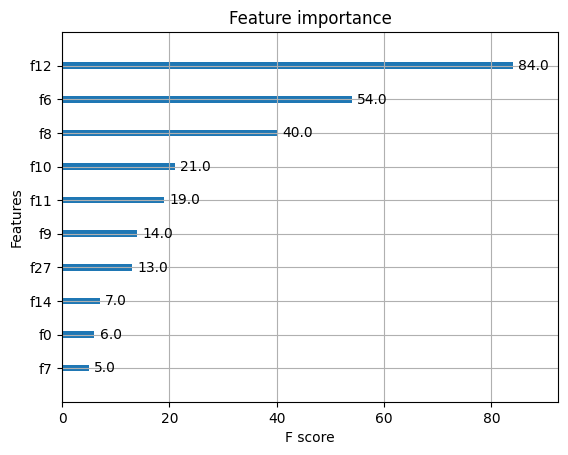

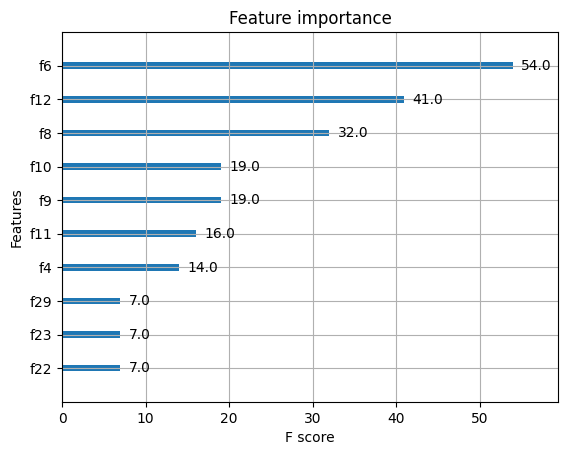

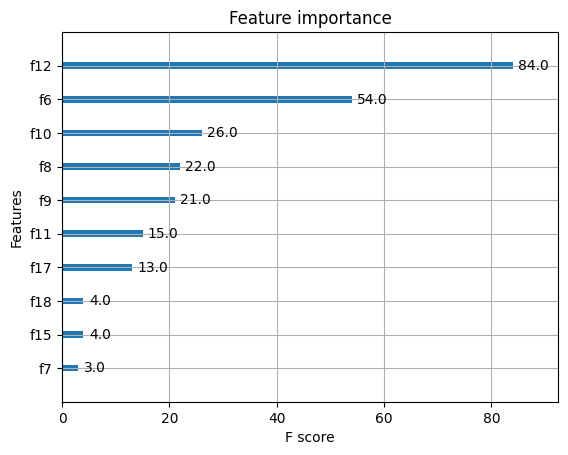

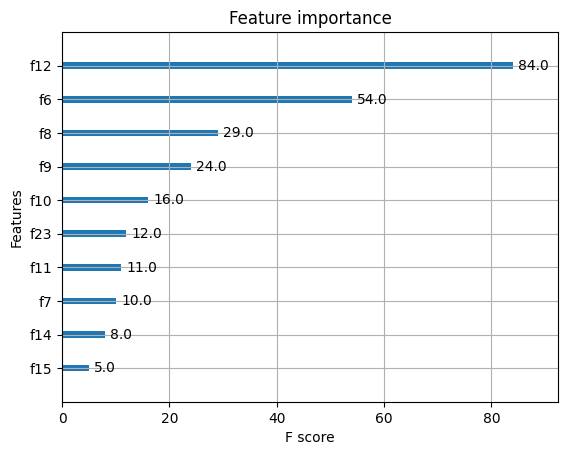

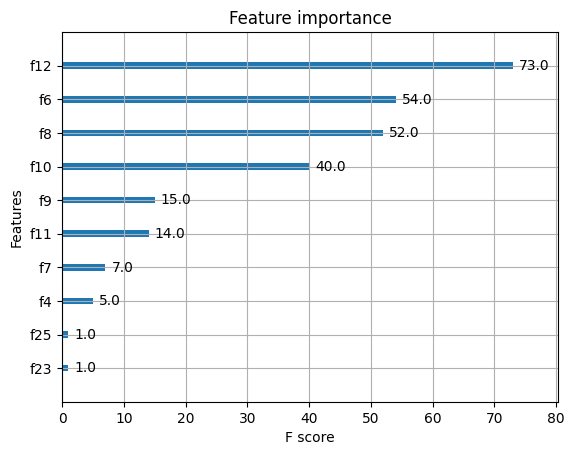

In [13]:
for symbol in symbols:
    print(symbol)
    data = yf.download(symbol,start_date,end_date)
    data = create_features(data,'Open')
    data_mo = modify_df(data) 
    x_train,x_test,y_train,y_test = data_split(data_mo,'2018','2019')
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test) 
    stack = modelBuildXGB(x_train_scaled,y_train,200,0.0001,3,3,0.3,0.5)
    y_pred = stack.predict(x_test_scaled) 
    print(confusion_matrix(y_test,y_pred))
    accuracy = accuracy_score(y_test,y_pred)
    print('Accuracy : ',accuracy)    
    auc = roc_auc_score(y_test,y_pred)
    print('AUC: ', auc) 
    print(f'Plot feature importances...{symbol}') 
    plot_importance(stack, max_num_features=10)

[*********************100%%**********************]  1 of 1 completed

---------- HDFCBANK.NS ----------
Epoch 1/10


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6634 - loss: 0.6018 - val_accuracy: 0.8690 - val_loss: 0.3152
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9151 - loss: 0.2867 - val_accuracy: 0.8690 - val_loss: 0.2751
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9338 - loss: 0.2288 - val_accuracy: 0.8810 - val_loss: 0.3069
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9680 - loss: 0.1515 - val_accuracy: 0.8810 - val_loss: 0.3076
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9612 - loss: 0.1343 - val_accuracy: 0.8929 - val_loss: 0.2490
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9248 - loss: 0.1630 - val_accuracy: 0.9167 - val_loss: 0.2165
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9384 - loss: 0.1567 - val_accuracy: 0.9405 - val_loss: 0.1661
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9852 - loss: 0.0786 - val_accuracy: 0.9167 - val_loss: 0.1889
Epo

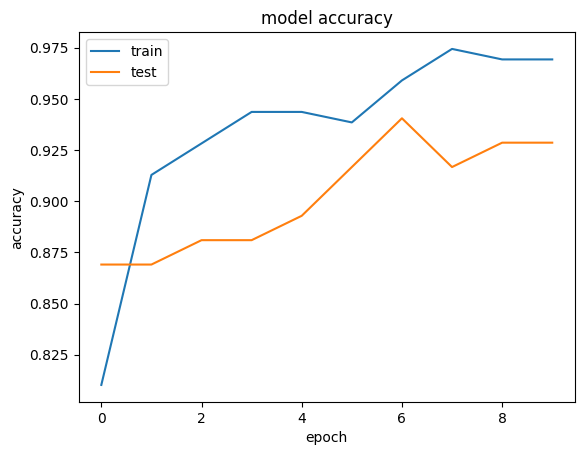

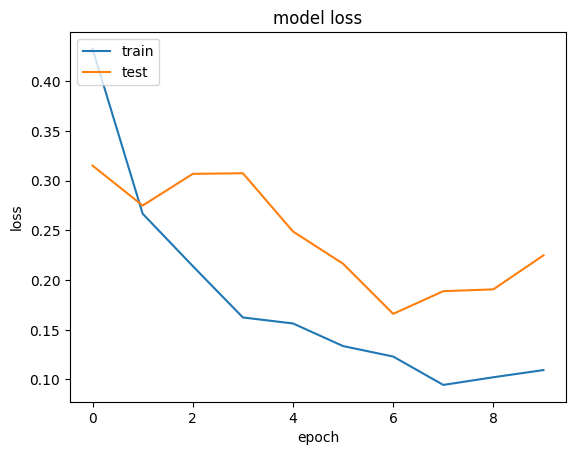

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed

Accuracy :  92.27799227799228  %
Confusion Matrix : 
[[124   8]
 [ 12 115]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       132
           1       0.93      0.91      0.92       127

    accuracy                           0.92       259
   macro avg       0.92      0.92      0.92       259
weighted avg       0.92      0.92      0.92       259

AUC Score :  0.9224528752087807
---------- ICICIBANK.NS ----------
Epoch 1/10


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7126 - loss: 0.5098 - val_accuracy: 0.8571 - val_loss: 0.3554
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9343 - loss: 0.2115 - val_accuracy: 0.9048 - val_loss: 0.2791
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9190 - loss: 0.1696 - val_accuracy: 0.8810 - val_loss: 0.3157
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9512 - loss: 0.1519 - val_accuracy: 0.8095 - val_loss: 0.7457
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9660 - loss: 0.1145 - val_accuracy: 0.9167 - val_loss: 0.2327
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9734 - loss: 0.1069 - val_accuracy: 0.9167 - val_loss: 0.2596
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9865 - loss: 0.0826 - val_accuracy: 0.9167 - val_loss: 0.2265
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9937 - loss: 0.0662 - val_accuracy: 0.9524 - val_loss: 0.1710
Epo

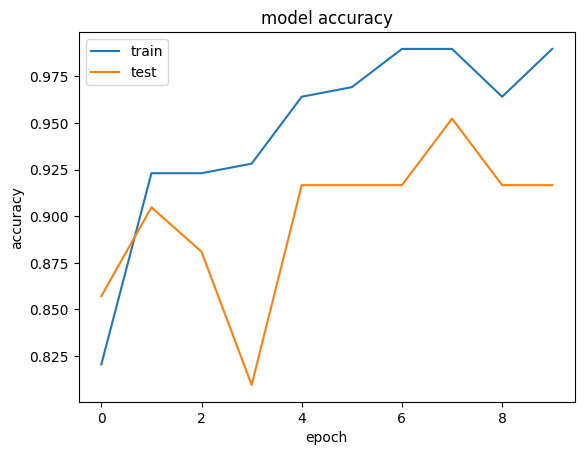

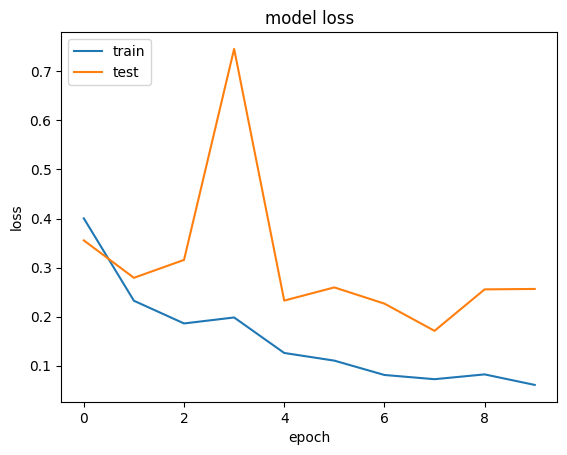

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%%**********************]  1 of 1 completed

Accuracy :  85.71428571428571  %
Confusion Matrix : 
[[125   3]
 [ 34  97]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       128
           1       0.97      0.74      0.84       131

    accuracy                           0.86       259
   macro avg       0.88      0.86      0.86       259
weighted avg       0.88      0.86      0.86       259

AUC Score :  0.8585102576335878
---------- SBIN.NS ----------
Epoch 1/10


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8335 - loss: 0.4464 - val_accuracy: 0.9167 - val_loss: 0.2405
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9275 - loss: 0.1871 - val_accuracy: 0.9405 - val_loss: 0.1970
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9284 - loss: 0.1886 - val_accuracy: 0.9048 - val_loss: 0.1925
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9215 - loss: 0.1812 - val_accuracy: 0.9167 - val_loss: 0.1973
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9504 - loss: 0.1194 - val_accuracy: 0.8810 - val_loss: 0.2070
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9693 - loss: 0.1265 - val_accuracy: 0.9167 - val_loss: 0.1869
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9908 - loss: 0.0843 - val_accuracy: 0.9167 - val_loss: 0.2066
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9871 - loss: 0.0960 - val_accuracy: 0.9167 - val_loss: 0.2174
Epo

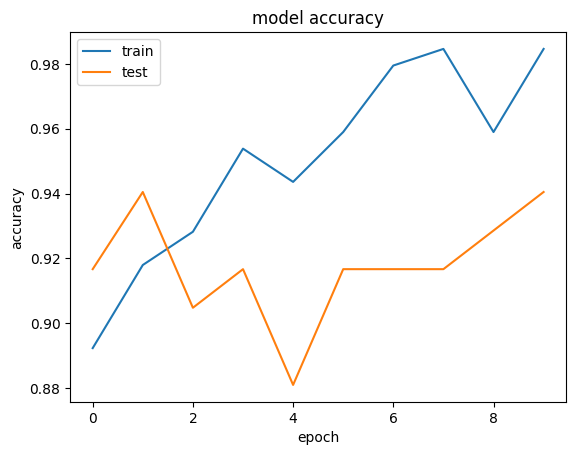

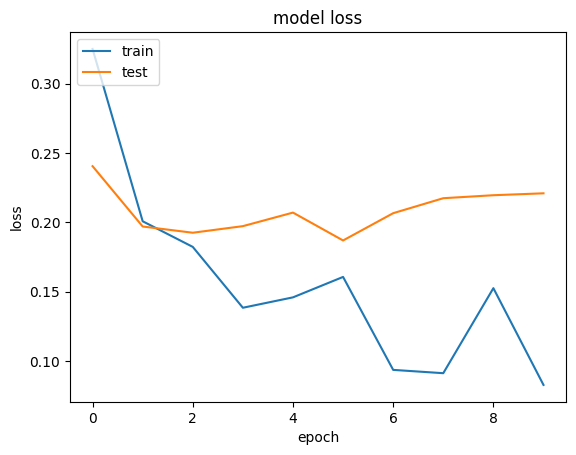

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed

Accuracy :  81.85328185328186  %
Confusion Matrix : 
[[ 84  46]
 [  1 128]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.99      0.65      0.78       130
           1       0.74      0.99      0.84       129

    accuracy                           0.82       259
   macro avg       0.86      0.82      0.81       259
weighted avg       0.86      0.82      0.81       259

AUC Score :  0.819200954084675
---------- KOTAKBANK.NS ----------
Epoch 1/10


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7242 - loss: 0.5420 - val_accuracy: 0.8810 - val_loss: 0.2797
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9111 - loss: 0.2078 - val_accuracy: 0.8690 - val_loss: 0.3110
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9662 - loss: 0.1612 - val_accuracy: 0.9643 - val_loss: 0.1874
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9387 - loss: 0.1591 - val_accuracy: 0.9167 - val_loss: 0.2342
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9445 - loss: 0.1416 - val_accuracy: 0.9048 - val_loss: 0.2163
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9756 - loss: 0.1347 - val_accuracy: 0.8929 - val_loss: 0.2866
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9838 - loss: 0.0871 - val_accuracy: 0.9167 - val_loss: 0.3164
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9943 - loss: 0.0901 - val_accuracy: 0.7976 - val_loss: 0.7572
Epo

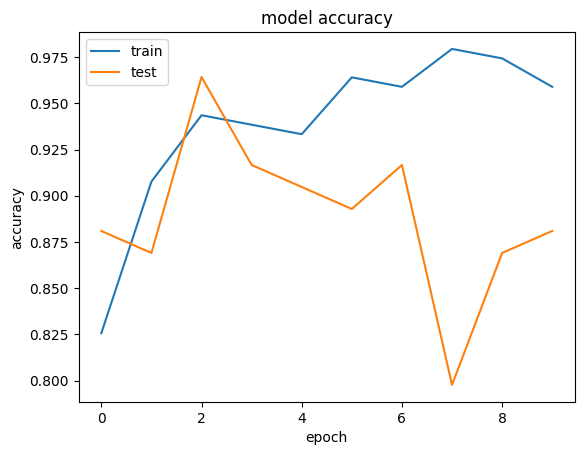

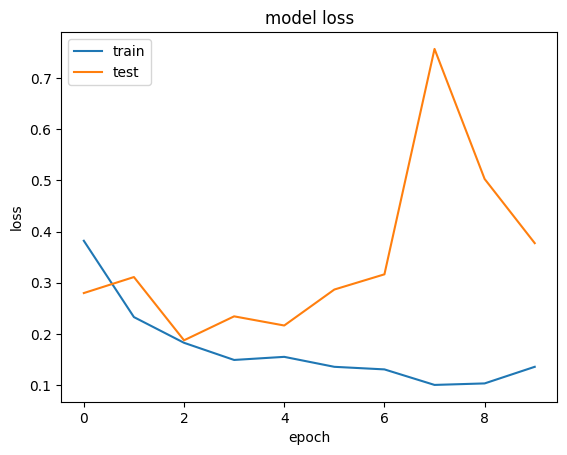

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed

Accuracy :  79.92277992277992  %
Confusion Matrix : 
[[123   2]
 [ 50  84]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.71      0.98      0.83       125
           1       0.98      0.63      0.76       134

    accuracy                           0.80       259
   macro avg       0.84      0.81      0.79       259
weighted avg       0.85      0.80      0.79       259

AUC Score :  0.8054328358208955
---------- AXISBANK.NS ----------
Epoch 1/10


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7340 - loss: 0.5103 - val_accuracy: 0.9167 - val_loss: 0.2306
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9124 - loss: 0.2644 - val_accuracy: 0.9405 - val_loss: 0.1955
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9081 - loss: 0.2570 - val_accuracy: 0.9167 - val_loss: 0.1720
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9333 - loss: 0.1580 - val_accuracy: 0.9524 - val_loss: 0.1509
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9555 - loss: 0.1543 - val_accuracy: 0.9405 - val_loss: 0.1551
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9498 - loss: 0.1315 - val_accuracy: 0.9286 - val_loss: 0.1484
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9774 - loss: 0.1146 - val_accuracy: 0.9405 - val_loss: 0.1477
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9699 - loss: 0.0947 - val_accuracy: 0.9286 - val_loss: 0.2156
Epo

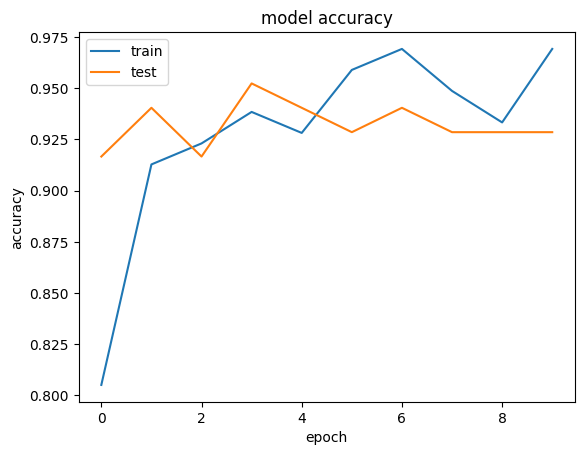

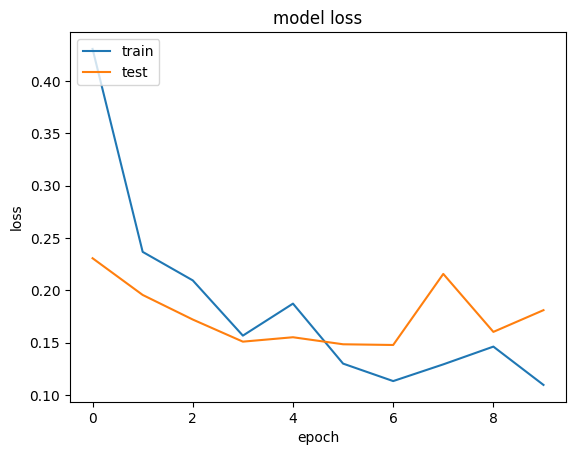

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy :  96.52509652509652  %
Confusion Matrix : 
[[128   5]
 [  4 122]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       133
           1       0.96      0.97      0.96       126

    accuracy                           0.97       259
   macro avg       0.97      0.97      0.97       259
weighted avg       0.97      0.97      0.97       259

AUC Score :  0.9653299916457811


In [25]:
for symbol in symbols:
    print('-'*10,symbol,'-'*10) 
    data = yf.download(symbol,start=start_date,end=end_date)
    data = create_features(data,'Open')
    data_mo = modify_df(data) 
    x_train,x_test,y_train,y_test = data_split(data_mo,'2018','2019')
    scaler = StandardScaler() 
    X_train_scaled = scaler.fit_transform(x_train)
    X_test_scaled = scaler.transform(x_test) 
    optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    unit = 20
    kernel_init = 'glorot_normal'
    activation = 'relu'
    reg = l1(0.001) 
    model.save('model.keras')  
    checkpoint = keras.callbacks.ModelCheckpoint('model.keras', verbose=0, monitor='val_acc',save_best_only=True, mode='auto')
    stoppoint = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500)
    batch_size = 2 
    epochs = 10  
    threshold = 0.5
    model = None
    model = create_model(X_train_scaled,unit,optimizer,kernel_init,activation,reg)
    history = train_model(model, X_train_scaled, y_train,checkpoint,stoppoint,batch_size,epochs)
    accuracy_history = history.history['accuracy']
    val_accuracy_history = history.history['val_accuracy']
    print("Last training accuracy: ",str(accuracy_history[-1]), ", last validation accuracy: ",str(val_accuracy_history[-1]))
    plotHistory(history) 
    plotMetrics(threshold, X_test_scaled, y_test)    